# Tutorial

This notebook provides a quick introduction to using FACSIMILE to generate a reduced set of questionnaire items which can be used to accurately predict factor scores.

In [1]:
%load_ext autoreload
%autoreload 2

First, import the necessary packages:

In [5]:
from facsimile.plotting import plot_predictions
from facsimile.eval import FACSIMILEOptimiser
from facsimile.utils import train_validation_test_split
import pandas as pd

## Data

Next, we load the data. Here we're using data from Hopkins et al. (2022).

In [6]:
items = pd.read_csv("../data/items.csv")
factor_scores = pd.read_csv("../data/factor_scores.csv")


It is important to split the data into three sets: training, validation, and test. The training set is used to fit the model, the validation set is used to select the best hyperparameter values, and the test set is used to evaluate the optimised model's performance. We can do this using the provided `train_validate_test_split` utility function.

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    items.iloc[:, 2:],  # Drop the first two columns, which are just IDs
    factor_scores.iloc[:, 2:],  # Drop the first two columns, which are just IDs
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

## Run the optimiser

The `FACSIMILEOptimiser` class runs an random search across the hyperparameter space to find regalularisation hyperparameter values that provide the best performance on the validation set. 

It is worth running a large number of iterations (e.g., 1000) to ensure that the optimiser has a good chance of finding the best hyperparameter values. However, this can take a long time. To speed things up, we can run the optimiser in parallel across multiple cores. This is done by setting the `n_jobs` parameter to the number of cores to use.

> Note: Here we only run 100 iterations for speed

In [9]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=100, n_jobs=10)

# Fit 
optimiser.fit(X_train, y_train, X_val, y_val, factor_names=['AD', 'Compul', 'SW'])

Evaluation: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


### View the results

The optimiser stores the results of each iteration in a pandas DataFrame. We can view the results using the `results_` attribute.

This contains columns representing the $R^2$ score for each factor on the validation set, the minimum $R^2$ score across all factors, and the hyperparameter values used for each iteration. We also get the number of items retained on each iteration, along with a `score` variable that balances the number of items retained with the minimum $R^2$ score according to the following formula:


$$\text{score} = \min(R^2) \cdot \left(1 - \frac{n_{included}}{n_{total}}\right)$$

Where $n_{included}$ is the number of items included, and $n_{total}$ is the total number of items.


In [11]:
optimiser.results_.head()

,run,r2_AD,r2_Compul,r2_SW,min_r2,scores,n_items,alpha_AD,alpha_Compul,alpha_SW
0,0,0.918472,0.944004,0.990711,0.918472,0.646007,62,0.648454,0.088522,0.050141
1,1,0.943385,0.797884,0.982315,0.797884,0.645179,40,0.281767,0.451665,0.067217
2,2,0.921996,0.754960,0.970634,0.754960,0.632144,34,0.422915,0.377139,0.120488
3,3,0.959981,0.944234,0.984295,0.944234,0.655091,64,0.263594,0.084933,0.173436
4,4,0.943833,0.838659,0.972880,0.838659,0.670125,42,0.267312,0.321228,0.095243


### Get the best classifier

We can get the best classifier from the optimiser using the `get_best_classifier` method. This returns a `FACSIMILEClassifier` object which can be used to predict factor scores for new participants.

The classifier is returned unfitted (i.e., just initialised with the best alpha values), so we then need to call the `fit` method to fit the classifier to the training data.

In [12]:
# Get the best classifier
best_clf = optimiser.get_best_classifier()

# Fit
best_clf.fit(X_train, y_train)

# Print number of included items
print("Number of included items: {}".format(best_clf.included_items.sum()))

Number of included items: 34


We can then predict factor scores for the test data using the `predict` method and plot the predicted scores against the true scores.

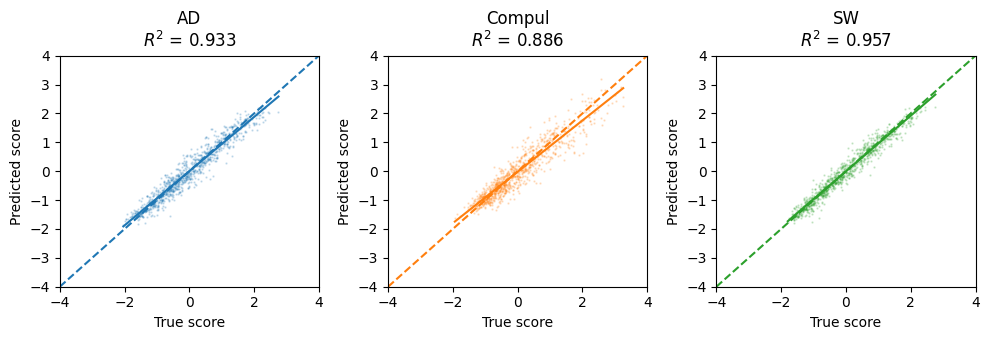

In [13]:
# Get predictions
y_pred = best_clf.predict(X_test)

# Plot
plot_predictions(y_test, y_pred, ['AD', 'Compul', 'SW'], scale=1)

### Get the best classifier for a given number of items

We can also get the best classifier for a given number of items using the `get_best_classifier_max_items` method. This will do the same as above, but only select from classifiers that include up the number of items indicated.

Here we'll get the best classifier that includes up to 70 items.

In [14]:
# Get the best classifier
best_clf_70 = optimiser.get_best_classifier_max_items(70)

# Fit
best_clf_70.fit(X_train, y_train)

# Print number of included items
print("Number of included items: {}".format(best_clf_70.included_items.sum()))

Number of included items: 70


Again, we can plot the predicted scores against the true scores.

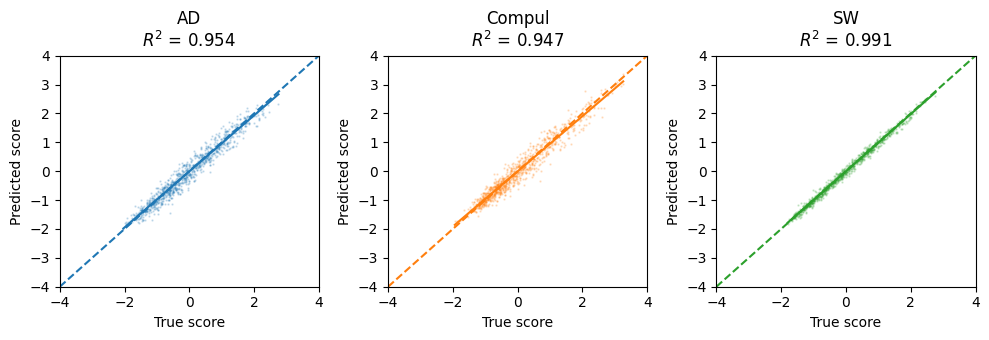

In [15]:
# Get predictions
y_pred_70 = best_clf_70.predict(X_test)

# Plot
plot_predictions(y_test, y_pred_70, ['AD', 'Compul', 'SW'], scale=1)